# roberta-large-bne-finetuned-mldoc

En el presente colab, se entrena un modelo para clasificaciond e 4 diferentes tipos de resoluciones


*   Infraestructura y Recursos
*   Nombramientos de Personal
*   Aprobaciones de Planes
*   Modificaciones Reglamentaria



In [ ]:
!pip install transformers datasets tensorflow huggingface_hub -q > /dev/null 2>&1

In [ ]:
!pip install "numpy<2.0"

Reiniciar sesión después de instalar los paquetes

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.utils.class_weight import compute_class_weight
from tf_keras.callbacks import EarlyStopping

# CARGAR DATA REAL

In [ ]:
#Algoritmo para armar el dataset dado un csv
'''
import pandas as pd
from datasets import Dataset, DatasetDict

from google.colab import drive
drive.mount('/content/drive')

# Leer el archivo CSV
rawdf = pd.read_csv("/content/drive/MyDrive/YARUQUI/data/dataTraining.csv", sep=",")
# Contar ejemplos por categoría
class_distribution = rawdf['id_category'].value_counts()
print(class_distribution)

from sklearn.model_selection import train_test_split
#Renombro las columnas
dfrenamed = rawdf.rename(columns={"text": "body",
    "id": "idx", "id_category": "label"
})
df = dfrenamed[["body", "label", "idx"]].copy()

# train (80%) y temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=123, stratify=df['label'])

# validation (10%) y test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=123, stratify=temp_df['label'])

train_dataset_hf = Dataset.from_pandas(train_df)
val_dataset_hf = Dataset.from_pandas(val_df)
test_dataset_hf = Dataset.from_pandas(test_df)

# Creacion de DatasetDict
dataset = DatasetDict({
    "train": train_dataset_hf,
    "validation": val_dataset_hf,
    "test": test_dataset_hf
})

## GUARDAR EN HUGGING FACE
dataset.push_to_hub("aatituanav/roberta-base-bne-mldoc-4cat")
print(dataset)
'''
#Cargar los datos ya seteados desde el repo (En caso de no poseer el .csv)
from datasets import load_dataset
dataset = load_dataset("aatituanav/roberta-base-bne-mldoc-4cat")
dataset

DatasetDict({
    train: Dataset({
        features: ['body', 'label', 'idx', '__index_level_0__'],
        num_rows: 320
    })
    validation: Dataset({
        features: ['body', 'label', 'idx', '__index_level_0__'],
        num_rows: 40
    })
    test: Dataset({
        features: ['body', 'label', 'idx', '__index_level_0__'],
        num_rows: 40
    })
})

# ENTRENAR CON KERAS

In [ ]:
import tensorflow as tf ##2.18.0
print(tf.__version__)

2.19.0


In [ ]:
#Se carga el tokenizador
model_name = "dccuchile/roberta-base-bne-finetuned-mldoc"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["body"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

In [ ]:
# Aplicar tokenización
tokenized_datasets = dataset.map(tokenize_function, batched=True)
# Elimina las columnas de texto originales
tokenized_datasets = tokenized_datasets.remove_columns(["body"])
print("Columnas después de tokenizar:", tokenized_datasets["train"].column_names)


# ========== [Preparación de Datasets] ==========
# Convertir a formato TensorFlow
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

val_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Columnas después de tokenizar: ['label', 'idx', '__index_level_0__', 'input_ids', 'attention_mask']


/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

model = TFAutoModel.from_pretrained(model_name, from_pt=True, name="roberta_base")

#Construcción de la cabeza de clasificación
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

# Salida del modelo base (pasando todas las entradas)
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
pooled_output = outputs.last_hidden_state[:, 0, :]
dropout = tf.keras.layers.Dropout(0.7)(pooled_output)
classifier = tf.keras.layers.Dense(
    4,
    activation="softmax",
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(dropout)
#Definicion del modelo completo
model = tf.keras.Model(
    inputs=[input_ids, attention_mask],
    outputs=classifier,
    name="roberta_base_bne_finetuned_mldoc"
)

#Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

config.json:   0%|          | 0.00/980 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['classifier.out_proj.weight', 'roberta.embeddings.position_ids', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "roberta_base_bne_finetuned_mldoc"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 roberta_base (TFRobertaMod  TFBaseModelOutputWithPooli   1246433   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   28         'attention_mask[0][0]']      
                             hidden_state=(None, None,             

In [ ]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint 
#Parado temprano
early_stopping_acc = EarlyStopping(
    min_delta=0.0001,
    patience=3,
    restore_best_weights=True,
    verbose=1,
    monitor="val_loss",
    mode="min"
)


In [ ]:
#Ajuste del modelo
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping_acc],
)

Epoch 1/10


40/40 [==============================] - 66s 441ms/step - loss: 1.4693 - accuracy: 0.3719 - val_loss: 1.1063 - val_accuracy: 0.7500
Epoch 2/10
40/40 [==============================] - 9s 215ms/step - loss: 0.6833 - accuracy: 0.7969 - val_loss: 0.3077 - val_accuracy: 0.9500
Epoch 3/10
40/40 [==============================] - 8s 195ms/step - loss: 0.1937 - accuracy: 0.9719 - val_loss: 0.1440 - val_accuracy: 0.9750
Epoch 4/10
40/40 [==============================] - 7s 164ms/step - loss: 0.1097 - accuracy: 0.9969 - val_loss: 0.2159 - val_accuracy: 0.9750
Epoch 5/10
40/40 [==============================] - 6s 149ms/step - loss: 0.0866 - accuracy: 1.0000 - val_loss: 0.2736 - val_accuracy: 0.9750
Epoch 6/10
40/40 [==============================] - 6s 161ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.2627 - val_accuracy: 0.9750
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


# Métricas de desempeño

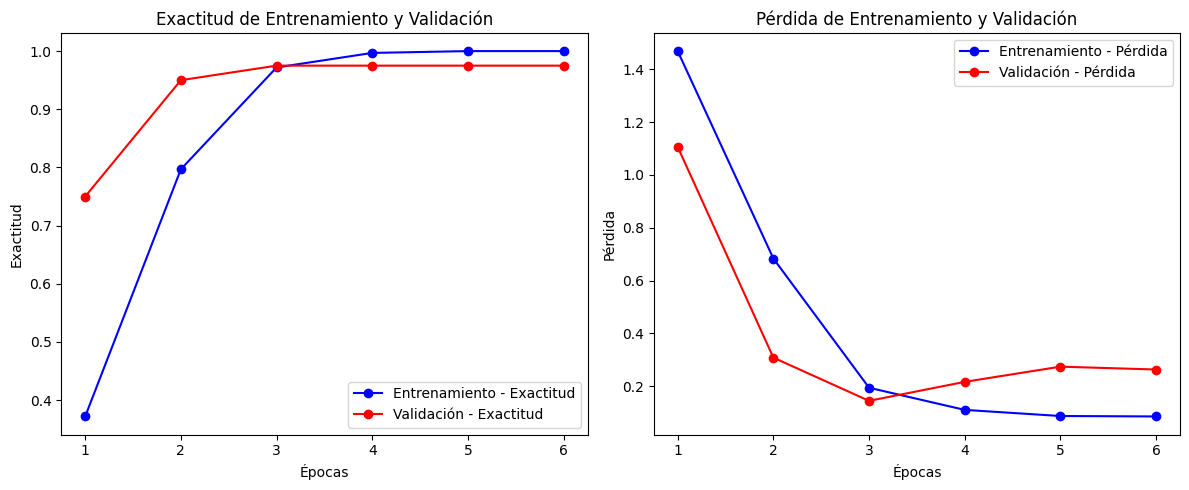

In [ ]:
import matplotlib.pyplot as plt

# Métricas del historial
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Estilo de los gráficos
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12, 5))

# Gráfico de exactitud
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Entrenamiento - Exactitud')
plt.plot(epochs, val_acc, 'ro-', label='Validación - Exactitud')
plt.title('Exactitud de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento - Pérdida')
plt.plot(epochs, val_loss, 'ro-', label='Validación - Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

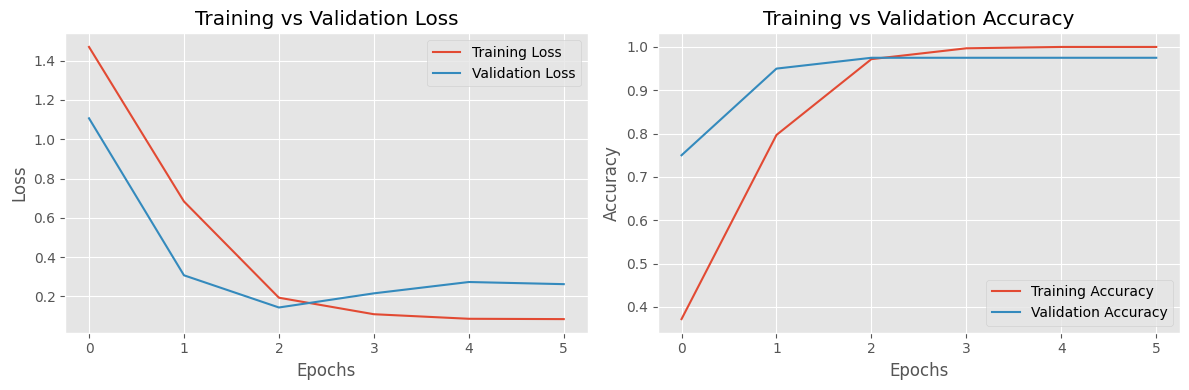

In [ ]:
import matplotlib.pyplot as plt

# Estilo de los gráficos
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de pérdida (loss)
ax1.plot(history["loss"], label="Training Loss")
ax1.plot(history["val_loss"], label="Validation Loss")
ax1.set_title("Training vs Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Gráfico de precisión (accuracy)
ax2.plot(history["accuracy"], label="Training Accuracy")
ax2.plot(history["val_accuracy"], label="Validation Accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.tight_layout()


plt.show()

### TEST

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


print("Generando predicciones en el conjunto de test...")

# Predicción en batches (para conjuntos más grandes en un futuro)
all_logits = []
for batch in test_dataset:
    inputs = {key: val for key, val in batch[0].items()}
    logits = model.predict(inputs, verbose=0)
    all_logits.append(logits)

test_predictions_logits = np.concatenate(all_logits, axis=0)

# Estracción de las clases predichas
y_pred = np.argmax(test_predictions_logits, axis=1)

# Obtenención de las etiquetas verdaderas del conjunto de test
y_true = []
print("Extrayendo etiquetas verdaderas del conjunto de test...")
for features, label in test_dataset.unbatch():
    y_true.append(label.numpy())
y_true = np.array(y_true)

# Verificacion adicional del numero de etiquetas con numero de predicciones
print(f"Número de predicciones: {len(y_pred)}")
print(f"Número de etiquetas verdaderas: {len(y_true)}")
assert len(y_pred) == len(y_true), "¡Las longitudes de las predicciones y las etiquetas verdaderas no coinciden!"


class_names = ["0", "1", "2", "3"]

# 5. Presición en el conjunto de prueba
accuracy = accuracy_score(y_true, y_pred)
print(f"\nExactitud en el conjunto de test: {accuracy:.4f}")

print("\nReporte de Clasificación:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


Generando predicciones en el conjunto de test...
Extrayendo etiquetas verdaderas del conjunto de test...
Número de predicciones: 40
Número de etiquetas verdaderas: 40
Nombres de las clases: ['0', '1', '2', '3']

Exactitud en el conjunto de test: 0.9250

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        10
           1     1.0000    1.0000    1.0000        10
           2     0.8182    0.9000    0.8571        10
           3     1.0000    0.9000    0.9474        10

    accuracy                         0.9250        40
   macro avg     0.9295    0.9250    0.9261        40
weighted avg     0.9295    0.9250    0.9261        40

Reporte, exactitud y historial por época guardados en: /content/drive/MyDrive/YARUQUI/runs/epoc3_roberta_base_drop07/reporte_clasificacion.txt


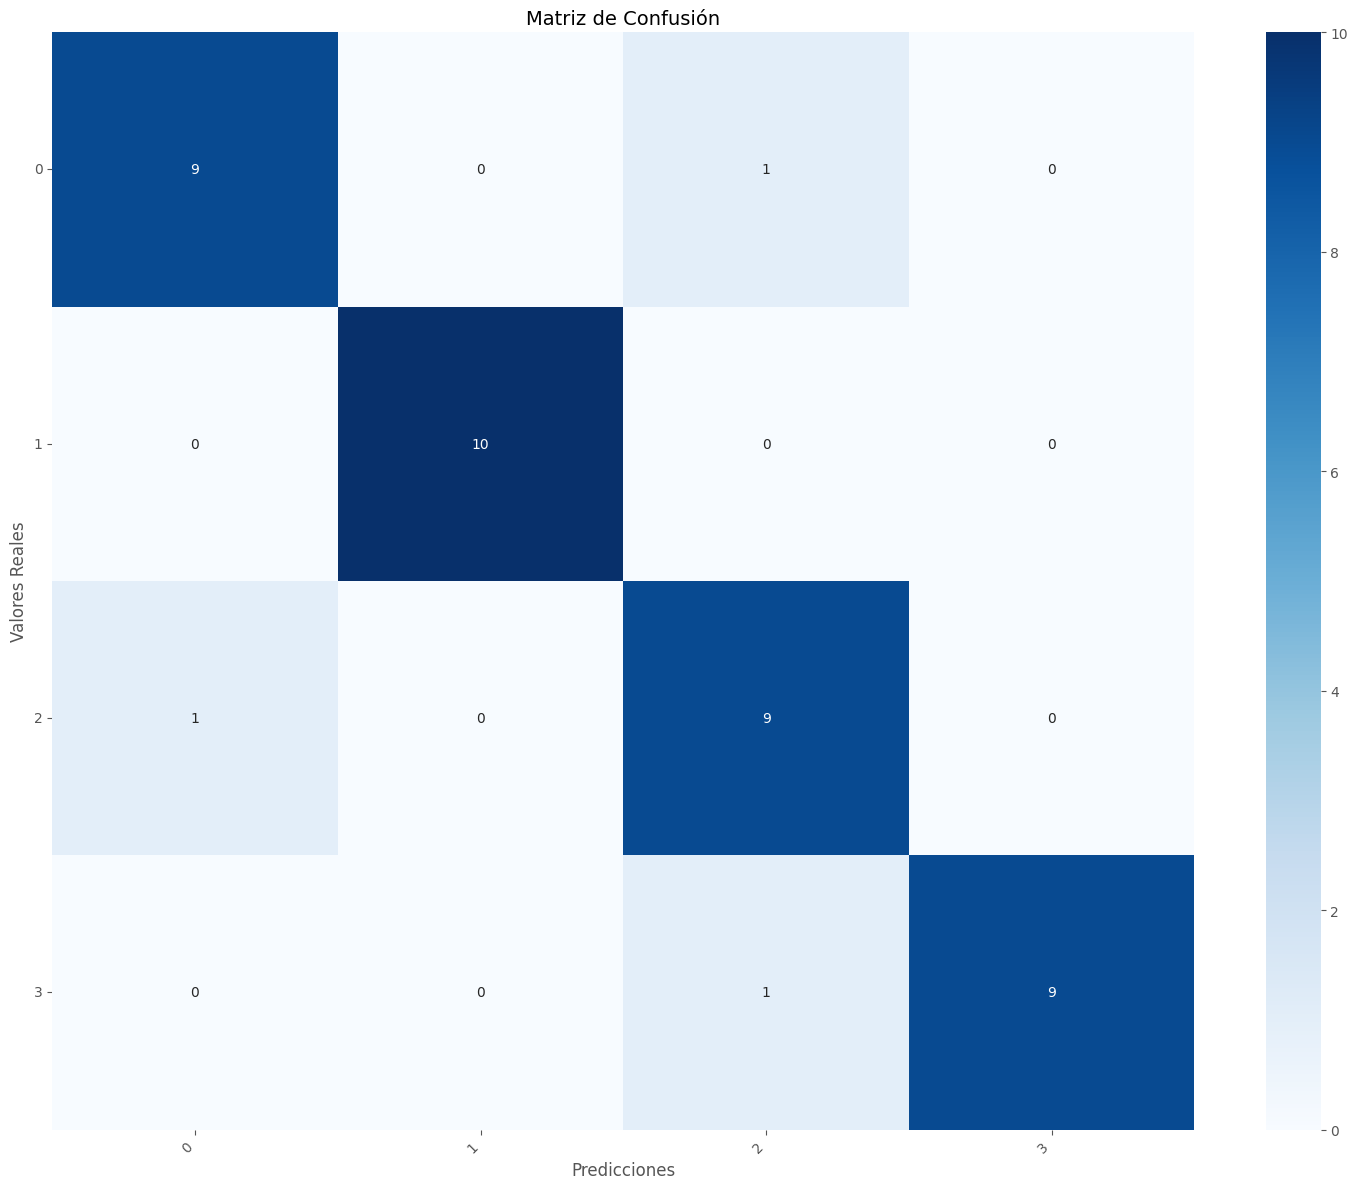

In [ ]:
# Matriz de confusión
label_names = ["0", "1", "2", "3"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Valores Reales', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()